In [1]:
import pandas as pd
import numpy as np
import ot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import BaseTransport, calc_parsimony

In [2]:
# Experiment hyperparamters
rng = np.random.RandomState(42)

In [3]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

## Loading and Preprocessing the data


In [4]:
from data_utils import load_and_preprocess_nba_data
continuous_variables_indicies = [0,1,2]
# n_samples = 'balanced'
# n_samples = 1000
X, Y, feature_names = load_and_preprocess_nba_data(rng, return_column_names=True)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
print(X)
print(Y)
source_target_path = open('./File_Paths/path_source_target.txt', 'r').read()
parameters = pd.read_csv(f'../{source_target_path}/experiment_parameters.csv')
split_on = parameters['split_feature'].values[0]
instance_1 = parameters['instance_1'].values[0]
instance_2 = parameters['instance_2'].values[0]


Splitting on Team with OKC and MIN resulting source shape: (131, 3), target shape: (131, 3).
###############################
['Age', 'GamesPlayed', 'NetScoreOfPlayer']
###############################
######################## Source_Data_A Dropped ##########################
     Age  GamesPlayed  NetScoreOfPlayer
55    24            2               -21
40    28            6               -22
19    26            7               -50
31    25            5               -39
115   33           14                26
..   ...          ...               ...
71    34           18               -40
106   22           17                51
14    35            7               -38
92    21            1                -4
102   24           17                20

[131 rows x 3 columns]
########################### Source_Data_B Dropped #######################
     Age  GamesPlayed  NetScoreOfPlayer
115   33            3               -32
120   28            6                -2
49    21            3       

## Performing Clustering

In [5]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [6]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [7]:
## Hyperparameters
max_clusters = 10

In [8]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0

################################################################################################################################################
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, Z=Z_continuous, n_clusters=n_clusters, rng=rng) 
    
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 1.508, Par: 0.000, Inter: 0


Fid: 0.847, Par: 86.636, Inter: 1
Fid: 0.822, Par: 88.855, Inter: 2


Fid: 0.588, Par: 113.395, Inter: 3
Fid: 0.584, Par: 117.647, Inter: 4


Fid: 0.436, Par: 138.903, Inter: 5


Fid: 0.396, Par: 145.254, Inter: 6
Fid: 0.394, Par: 146.120, Inter: 7


Fid: 0.377, Par: 147.685, Inter: 8
Fid: 0.343, Par: 156.521, Inter: 9


Fid: 0.369, Par: 148.721, Inter: 10


In [9]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on Team:


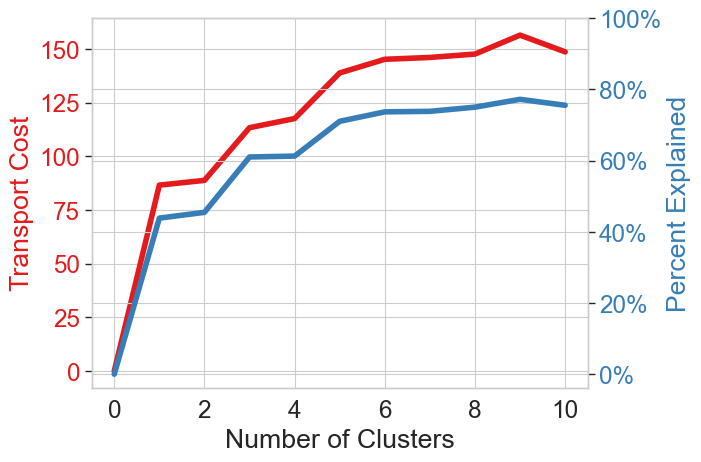

In [10]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)


print(f'Results with splitting on {split_on}:')
if save_figures: plt.savefig(
    figure_dir / f'logitics_data_on{split_on}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

In [11]:
nba_dict = {}
for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    tgt = f'{instance_2}'
    src = f'{instance_1}'
    nba_dict[record_idx] = {}
    print(f'Starting {n_clusters} cluster results:')
    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t         Names={[name[:3] for name in feature_names]}')
            print(f'\t\t   {src}_mean={X[cluster_idx==labels].mean(axis=0)}')
            print(f'\t\tT({tgt})_mean={Z_clusters[cluster_idx==labels].mean(axis=0)}')
            nba_dict[record_idx][cluster_idx] = {}

            nba_dict[record_idx][cluster_idx]['src_means'] = X[cluster_idx==labels].mean(axis=0)
            nba_dict[record_idx][cluster_idx]['trg_means'] = Z_clusters[cluster_idx==labels].mean(axis=0)

        print()

      

Starting 1 cluster results:
	Cluster: 0
		         Names=['Age', 'Gam', 'Net']
		   OKC_mean=[25.939  9.107  2.183]
		T(MIN)_mean=[27.672  5.389 -8.809]

Starting 2 cluster results:
	Cluster: 0
		         Names=['Age', 'Gam', 'Net']
		   OKC_mean=[30.333  8.    -2.458]
		T(MIN)_mean=[ 32.      5.229 -11.396]
	Cluster: 1
		         Names=['Age', 'Gam', 'Net']
		   OKC_mean=[23.398  9.747  4.867]
		T(MIN)_mean=[25.169  5.482 -7.313]

Starting 3 cluster results:
	Cluster: 0
		         Names=['Age', 'Gam', 'Net']
		   OKC_mean=[ 23.424   6.593 -11.119]
		T(MIN)_mean=[ 24.525   3.729 -15.915]
	Cluster: 1
		         Names=['Age', 'Gam', 'Net']
		   OKC_mean=[30.643  7.31  -8.667]
		T(MIN)_mean=[ 32.024   4.524 -15.095]
	Cluster: 2
		         Names=['Age', 'Gam', 'Net']
		   OKC_mean=[24.3   16.567 43.533]
		T(MIN)_mean=[27.767  9.867 13.967]

Starting 4 cluster results:
	Cluster: 0
		         Names=['Age', 'Gam', 'Net']
		   OKC_mean=[ 23.704  10.63  -32.556]
		T(MIN)_mean=[ 24.519   5.926 -

In [12]:
# # Assuming max_clusters and nba_dict are predefined elsewhere in your script
# vis_clusters = max_clusters
# total_distance = []
# attributes_list_names = feature_names

# # Initialize differences for each cluster
# for cluster_idx in range(0, vis_clusters):
#     nba_dict[vis_clusters-1][cluster_idx]["differences"] = {}

# # Calculate distances for all clusters and attributes
# for cluster_idx in range(0, vis_clusters):
#     for i, attribute in enumerate(attributes_list_names):
#         val_0 = nba_dict[vis_clusters-1][cluster_idx]['src_means'][i]
#         val_1 = nba_dict[vis_clusters-1][cluster_idx]['trg_means'][i]
#         nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute] = abs(val_1 - val_0)

#     # Calculate the total distance for the cluster
#     total_distance.append(np.sqrt(sum((nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute]) ** 2 for attribute in attributes_list_names)))

# # Create a DataFrame with the calculated differences
# distances = pd.DataFrame({
#     'Cluster': range(vis_clusters),
#     'Total_distance': total_distance
# })

# # Add each attribute's differences as a separate column
# for attribute in attributes_list_names:
#     distances[attribute] = [nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute] for cluster_idx in range(vis_clusters)]

# # Sort distances by total distance
# distances = distances.sort_values(by='Total_distance')

# display(distances)
# distance_folder_path = open('./File_Paths/path_distances.txt', 'r').read()
# output_path = f'../{distance_folder_path}/distance_from_{instance_1}_to_{instance_2}.csv'
# distances.to_csv(output_path, index=False)


In [13]:
# Initialization of nba_dict
vis_clusters = max_clusters
total_distance = []
attributes_list_names = feature_names
nba_dict = {}

# Process clusters and calculate means
for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    tgt = f'{instance_2}'
    src = f'{instance_1}'
    nba_dict[record_idx] = {}

    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):  # Iterate only over existing clusters
            nba_dict[record_idx][cluster_idx] = {
                'src_means': X[cluster_idx == labels].mean(axis=0),
                'trg_means': Z_clusters[cluster_idx == labels].mean(axis=0),
                'differences': {}  # Initialize the 'differences' key here
            }

# Calculate distances
total_distance = []
parent_cluster = []
child_cluster  = []
for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    n_clusters = cluster_record['n_clusters']  # Get n_clusters for the current record
    for cluster_idx in range(n_clusters):  # Iterate only over existing clusters
        if cluster_idx in nba_dict[record_idx]:  
            for i, attribute in enumerate(attributes_list_names):
                val_0 = nba_dict[record_idx][cluster_idx]['src_means'][i]
                val_1 = nba_dict[record_idx][cluster_idx]['trg_means'][i]
                nba_dict[record_idx][cluster_idx]["differences"][attribute] = abs(val_1 - val_0)

            # Calculate total distance for each cluster
            distance = np.sqrt(sum((nba_dict[record_idx][cluster_idx]["differences"][attribute]) ** 2 for attribute in attributes_list_names))
            total_distance.append(distance)
            parent_cluster.append(record_idx)
            child_cluster.append(cluster_idx)

# Create DataFrame
distances = pd.DataFrame({
    'Cluster': range(len(total_distance)),
    'Total_distance': total_distance,
    'Parent_cluster': parent_cluster,
    'Child_cluster': child_cluster
})

# Add attribute differences
for attribute in attributes_list_names:
    distances[attribute] = [
        nba_dict[record_idx][cluster_idx]["differences"][attribute] 
        for record_idx in range(max_clusters) 
        for cluster_idx in range(cluster_histories[record_idx]['n_clusters'])  # Iterate only over existing clusters
    ]

# Sort distances by 'Total_distance'
distances = distances.sort_values(by='Total_distance')
print(instance_1)
# Output to CSV
distance_folder_path = open('./File_Paths/path_distances.txt', 'r').read()
output_path = f'../{distance_folder_path}/distance_from_{instance_1}_to_{instance_2}.csv'
distances.to_csv(output_path, index=False)

# Display the DataFrame
display(distances)

OKC


,Cluster,Total_distance,Parent_cluster,Child_cluster,Age,GamesPlayed,NetScoreOfPlayer
33,33,2.218829,7,5,2.000000,0.960000,0.040000
31,31,2.538731,7,3,1.035714,1.928571,1.285714
22,22,2.544711,6,1,1.866667,0.800000,1.533333
53,53,2.614837,9,8,1.176471,1.529412,1.764706
18,18,2.826403,5,3,1.032258,1.709677,2.000000
15,15,2.892226,5,0,1.666667,0.805556,2.222222
40,40,3.213833,8,4,0.235294,2.352941,2.176471
11,11,3.238736,4,1,1.621622,0.918919,2.648649
21,21,3.604695,6,0,0.166667,2.833333,2.222222
46,46,3.666667,9,1,0.200000,3.066667,2.000000
